In [2]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import xml.etree.ElementTree as ET
import cv2 as cv
from torch.utils.tensorboard import SummaryWriter

import warnings
warnings.filterwarnings("ignore")

# Создание Dataloader

In [297]:
def get_nonzero_target_values(target):
    target = dict(target)
    nonzero_indexes = torch.nonzero(target["boxes"], as_tuple=True)[0]
    target["boxes"] = torch.index_select(target["boxes"], 0, nonzero_indexes)
    target["labels"] = torch.index_select(target["labels"], 0, nonzero_indexes)
    return target

In [255]:
class FaceMaskDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms = None, slice_vals = None, max_boxes = 128):
        self.root = root
        self.transforms = transforms
        self.max_boxes = max_boxes
        annotations_path = list(sorted(os.listdir(os.path.join(root, "annotations"))))
        if slice_vals:
            size = len(annotations_path)
            annotations_path = annotations_path[int(size*slice_vals[0]) : int(size*slice_vals[1])]
        annotations = [self.__xml_to_dict(os.path.join(self.root, "annotations", path)) for path in annotations_path]
        self.targets = []
        for idx, annotation in enumerate(annotations):
            boxes = annotation["bndboxes"]
            labels = annotation["labels"]
            # convert everything into a torch.Tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.uint8)

            image_id = torch.tensor([idx])
            # Вычисление площади бокса для loss функции
            # area = boxes[:, 2] * boxes[:, 3]
            # suppose all instances are not crowd
            # iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
            target = {}
            target["boxes"] = boxes
            target["labels"] = labels
            target["image_id"] = image_id
            # target["area"] = area
            self.targets.append(target)
        self.images = []
        for img_path in [os.path.join(self.root, annotation["image_path"]) for annotation in annotations]:
            img = cv.imread(img_path)
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = np.array(img)
            self.images.append(img)
            
            
    def __getitem__(self, idx):
        # load images and masks
        img = self.images[idx].copy()
        target = dict(self.targets[idx])
        
        if self.transforms is not None:
            img, target = self.transforms((img, target))
        
        num_boxes = target["boxes"].shape[0]
        if self.max_boxes-num_boxes > 0:
            boxes = target["boxes"]
            labels = target["labels"]
            boxes = torch.cat((boxes, 
                               torch.zeros([self.max_boxes-num_boxes, 4], dtype=torch.float32)
                              ), 
                              dim=0)
            labels = torch.cat((labels, 
                                torch.zeros([self.max_boxes-num_boxes], dtype=torch.uint8)
                               ), 
                               dim=0)
            target["boxes"] = boxes
            target["labels"] = labels
        elif self.max_boxes-num_boxes < 0:
            raise Exception(f"Real boxes [{num_boxes}] greater than argument 'max_boxes'")
        # print(img.shape, target)
        return img, target

    def __len__(self):
        return len(self.targets)
    
    def __xml_to_dict(self, xml_file_path: str):
        """Iterates through all .xml files (generated by labelImg) in the given directory,
        and generates .txt files that comply with yolo format for each .xml file.
        """ 
        class_mapping = {'with_mask' : 1,
                         'without_mask' : 0,
                         'mask_weared_incorrect' : 0}

        tree = ET.parse(xml_file_path)
        root = tree.getroot()

        output = {}
        output["image_path"] = os.path.join(root.find("folder").text, root.find("filename").text)
        width, height = int(root.find('size')[0].text), int(root.find("size")[1].text)
        output["labels"] = []
        output["bndboxes"] = []
        for member in root.findall("object"):
            output["labels"].append(class_mapping.get(member[0].text))

            bndbox = [float(elem.text) for elem in member.find("bndbox")]
            bndbox_convert = self.__convert((width, height), bndbox)
            output["bndboxes"].append(bndbox_convert)

        return output
    
    def __convert(self, size: tuple, box: list):
        """Takes as input:  (width, height) of an image
                            (xmin, ymin, xmax, ymax) of the bounding box
           and returns (x, y, w, h) of the bounding box in yolo format.
        """   
        dw = 1./size[0]
        dh = 1./size[1]
        # x = (box[2] + box[0])/2.0
        # y = (box[3] + box[1])/2.0
        x = box[0]
        y = box[1]
        w = abs(box[2] - box[0])
        h = abs(box[3] - box[1])
        x = x*dw
        w = w*dw
        y = y*dh
        h = h*dh

        return (x, y, w, h)

In [252]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size: tuple):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, data):
        img, target = data
        # print("Rescale:", target)
        h, w = img.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        img = cv.resize(img, (new_w, new_h))

        return img, target


class RandomHorizontalFlip(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """
    def __call__(self, data):
        img, target = data
        # print("RandomHorizontalFlip:", target)
        # Рандомная генерация из [0, 1]
        if np.random.choice(2, 1)[0]:
            img = cv.flip(img, 1)
            for i, box in enumerate(target["boxes"]):
                target["boxes"][i][0] = 1 - box[0] - box[2]
        return img, target
    
    
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, data):
        img, target = data
        # print("RandomCrop:", target)
        h, w = img.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        img = img[top: top + new_h,
                      left: left + new_w]
        # Производим сдвиг
        boxes = target["boxes"] * torch.tensor([w, h, w, h]) - torch.tensor([left, top, 0, 0])
        # Преобразуем данные к координатам нового изображения
        boxes = boxes * torch.tensor([1 / new_w, 1 / new_h, 1 / new_w, 1 / new_h])
        # print("boxes:", boxes)
        # Уберём лишние боксы, которые за границей
        labels = target["labels"]
        real_boxes = []
        real_labels = []
        for i, box in enumerate(boxes):
            if box[0] < 0 or box[0] + box[2] > 1 or box[1] < 0 or box[1] + box[3] > 1:
                continue
            real_boxes.append(box)
            real_labels.append(labels[i])
        # print("real_boxes:", real_boxes)
        # print("real_labels:", real_labels)
        if not real_boxes:
            target["boxes"] = torch.tensor([])
            target["labels"] = torch.tensor([])
        else:
            target["boxes"] = torch.stack(real_boxes)
            target["labels"] = torch.tensor(real_labels)
            
        return img, target
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, data):
        img, target = data
        # print("ToTensor:", target)
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        img = img.transpose((2, 0, 1))
        img = torch.as_tensor(img, dtype=torch.uint8)
        return img, target

In [313]:
def img_with_box(img, target):
    img = img.numpy().transpose((1, 2, 0)).astype(np.uint8).copy() 
    target = dict(target)
    target = get_nonzero_target_values(target)
    # Рисуем боксы
    img_height, img_width = img.shape[:2]
    for label, box in zip(target["labels"], target["boxes"]):
        color = (0,255,0) if label else (255,0,0)
        label = "with mask" if label else "without mask"
        x, y, w, h = int(box[0] * img_width), int(box[1] * img_height), int(box[2] * img_width), int(box[3] * img_height)
        # print(x, y, w, h)
        cv.rectangle(img,(x,y),(x+w,y+h), color, 2)
        cv.putText(img, label,(x,y - 10),0,0.4,color)
    return img
    # plt.figure(figsize=(0.02*img_width, 0.02*img_height))
    # plt.axis('off')
    # plt.imshow(img)
    # plt.show()
    # print("Image size: ", (img_width, img_height))

In [266]:
train_dataset = FaceMaskDataset("../dataset", 
                                  transforms = transforms.Compose([
                                       Rescale(324),
                                       RandomHorizontalFlip(),
                                       RandomCrop(256),
                                       ToTensor()
                                  ]),
                                  slice_vals = (0, 0.8)  
                               )
test_dataset = FaceMaskDataset("../dataset", 
                                  transforms = transforms.Compose([
                                       Rescale(256),
                                       ToTensor()
                                  ]),
                                  slice_vals = (0.8, 1.0)  
                              )

In [257]:
# train_dataset.targets[0]

In [259]:
# train_dataset[0]

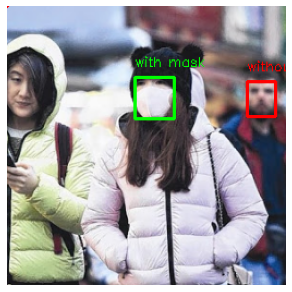

In [265]:
show_img_with_box(*train_dataset[0])

Разделение датасета по DataLoader

In [261]:
test_dataset_size = len(test_dataset)
valid_size = int(0.6 * test_dataset_size)
test_size  = int(0.4 * test_dataset_size)
test_size += test_dataset_size - valid_size - test_size
valid_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [valid_size, test_size])

In [276]:
train_dl = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
valid_dl = DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=0)
test_dl = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=0)

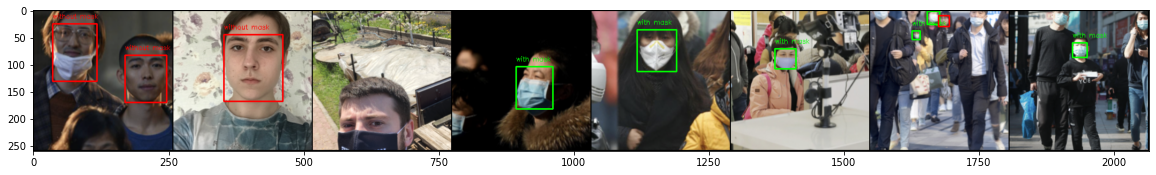

In [323]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Получим 1 батч (картнки-метки) из обучающей выборки
inputs, targets = next(iter(train_dl))
targets = [{"boxes": boxes, "labels": labels, "image_id": image_id}
                   for boxes, labels, image_id in 
                       zip(targets["boxes"], targets["labels"], targets["image_id"])]

# Расположим картинки рядом
out = [img_with_box(img, target) for img, target in zip(inputs, targets)]
out = utils.make_grid([torch.as_tensor(img.transpose((2, 0, 1)), dtype=torch.uint8) for img in out])

imshow(out)

## Модель

In [325]:
model = torch.hub.load('../yolov5l', 'yolov5l', source='local', classes=2, pretrained=True)

YOLOv5  2022-2-27 torch 1.10.2 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)

Overriding model.yaml nc=80 with nc=2

                 from  n    params  module                                  arguments                     
  0                -1  1      7040  models.common.Conv                      [3, 64, 6, 2, 2]              
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  3    156928  models.common.C3                        [128, 128, 3]                 
  3                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  4                -1  6   1118208  models.common.C3                        [256, 256, 6]                 
  5                -1  1   1180672  models.common.Conv                      [256, 512, 3, 2]              
  6                -1  9   6433792  models.common.C3                        [512, 512, 9]                 
  7                -1  1   4

In [ ]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    writer = SummaryWriter()
    train_losses = None
    val_losses = None
    valid_accuracies = []
    for epoch in range(epochs):
        model.train()
        loss_sum = 0
        for xb, yb in tqdm(train_dl):
            xb, yb = xb.to(device), yb.to(device)
            
            loss = loss_func(model(xb), yb)
            loss_sum += loss.item()
            
            loss.backward()
            opt.step()
            opt.zero_grad()
        train_losses = loss_sum / len(train_dl)

        model.eval()
        loss_sum = 0
        correct = 0
        num = 0
        with torch.no_grad():
            for xb, yb in tqdm(valid_dl):
                xb, yb = xb.to(device), yb.to(device)
                
                probs = model(xb)
                loss_sum += loss_func(probs, yb).item()
                
                _, preds = torch.max(probs, axis=-1)
                correct += (preds == yb).sum().item()
                num += len(xb)
                
        val_losses = loss_sum / len(valid_dl)
        valid_accuracies.append(correct / num)
        
    return train_losses, val_losses, valid_accuracies

In [82]:
def get_finetune_yolo():
    model = torch.hub.load('ultralytics/yolov5', 'yolov5l', classes=2, pretrained=True)
    # Замораживаем слои
    for param in model.model.model[:-1].parameters():
        param.requires_grad = False
        
    return model

In [83]:
model = get_finetune_yolo()

Using cache found in C:\Users\Domni/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-2-27 torch 1.10.2 CUDA:0 (NVIDIA GeForce GTX 1050 Ti, 4096MiB)

Overriding model.yaml nc=80 with nc=2

                 from  n    params  module                                  arguments                     
  0                -1  1      7040  models.common.Conv                      [3, 64, 6, 2, 2]              
  1                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  2                -1  3    156928  models.common.C3                        [128, 128, 3]                 
  3                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  4                -1  6   1118208  models.common.C3                        [256, 256, 6]                 
  5                -1  1   1180672  models.common.Conv                      [256, 512, 3, 2]              
  6                -1  9   6433792  models.common.C3    

In [ ]:
results

In [84]:
imgs = ['https://ultralytics.com/images/zidane.jpg']  # batch of images

# Inference
results = model(imgs)

# Results
results.print()
results.save()  # or .show()

results.xyxy[0]  # img1 predictions (tensor)
results.pandas().xyxy[0]  # img1 predictions (pandas)

image 1/1: 720x1280 (no detections)
Speed: 1136.1ms pre-process, 316.2ms inference, 1.0ms NMS per image at shape (1, 3, 384, 640)
Saved 1 image to runs\detect\exp4


,xmin,ymin,xmax,ymax,confidence,class,name
